# 컴퓨터 비전을 위한 딥러닝

## 합성곱 신경망 소개

**간단한 컨브넷 만들기**

In [1]:
from tensorflow import keras
from keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Metal device set to: Apple M2


**모델의 `summary()` 메서드 출력**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**MNIST 이미지에서 컨브넷 훈련하기**

In [3]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5


2023-05-24 21:07:18.375526: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


938/938 [==============================] - 10s 10ms/step - loss: 0.1504 - accuracy: 0.9540
Epoch 2/5
938/938 [==============================] - 10s 10ms/step - loss: 0.0436 - accuracy: 0.9863
Epoch 3/5
938/938 [==============================] - 10s 10ms/step - loss: 0.0313 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 9s 10ms/step - loss: 0.0225 - accuracy: 0.9932
Epoch 5/5
938/938 [==============================] - 9s 10ms/step - loss: 0.0168 - accuracy: 0.9948


**컨브넷 평가하기**

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트 정확도: {test_acc:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0299 - accuracy: 0.9910
테스트 정확도: 0.991


### 합성곱 연산

#### 경계 문제와 패딩 이해하기

#### 합성곱 스트라이등 이해하기

### 최대 풀링 연산

**최대 풀링 층이 빠진 잘못된 구조의 컨브넷**

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기

### 작은 데이터셋 문제에서 딥러닝의 타당성

### 데이터 내려받기

캐글에서 dogs-vs-cats 데이터셋을 다운로드하려면 캐글에 가입해야 한 후 생성한 API 키를 사용해야 합니다. 이런 과정이 번거롭다면 다음 명령으로 구글 드라이브에서 직접 다운로드할 수 있습니다.


그다음 아래 3개의 코드 셀을 건너 뛰고 바로 `unzip` 명령을 실행하세요.

In [7]:
!kaggle competitions download -c dogs-vs-cats

100%|███████████████████████████████████████▉| 812M/812M [00:15<00:00, 53.1MB/s]
100%|████████████████████████████████████████| 812M/812M [00:15<00:00, 55.0MB/s]


In [8]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

**이미지를 훈련, 검증, 테스트 디렉토리로 복사하기**

In [9]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### 모델 만들기

**강아지 vs. 고양이 분류를 위한 소규모 컨브넷 만들기**

In [10]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

**모델 훈련 설정하기**

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### 데이터 전처리

**`image_dataset_from_directory`를 사용하여 이미지 읽기**

In [13]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [14]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [15]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [16]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [17]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**`Dataset`이 반환하는 데이터와 레이블 크기 확인하기**

In [18]:
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기:", data_batch.shape)
    print("레이블 배치 크기:", labels_batch.shape)
    break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


**`Dataset`을 사용해 모델 훈련하기**

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 7s 102ms/step - loss: 0.7078 - accuracy: 0.5225 - val_loss: 0.6863 - val_accuracy: 0.5220
Epoch 2/30
63/63 [==============================] - 6s 96ms/step - loss: 0.7396 - accuracy: 0.5390 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 6s 96ms/step - loss: 0.6989 - accuracy: 0.5850 - val_loss: 0.6454 - val_accuracy: 0.6150
Epoch 4/30
63/63 [==============================] - 6s 95ms/step - loss: 0.6395 - accuracy: 0.6315 - val_loss: 0.7975 - val_accuracy: 0.5660
Epoch 5/30
63/63 [==============================] - 6s 95ms/step - loss: 0.6164 - accuracy: 0.6710 - val_loss: 0.6175 - val_accuracy: 0.6520
Epoch 6/30
63/63 [==============================] - 6s 95ms/step - loss: 0.5799 - accuracy: 0.7110 - val_loss: 0.6261 - val_accuracy: 0.6500
Epoch 7/30
63/63 [==============================] - 6s 96ms/step - loss: 0.5528 - accuracy: 0.7270 - val_loss: 0.5847 - val_accuracy: 0.6980
Epoch 8/30
6

**훈련 정확도와 손실 그래프 그리기**

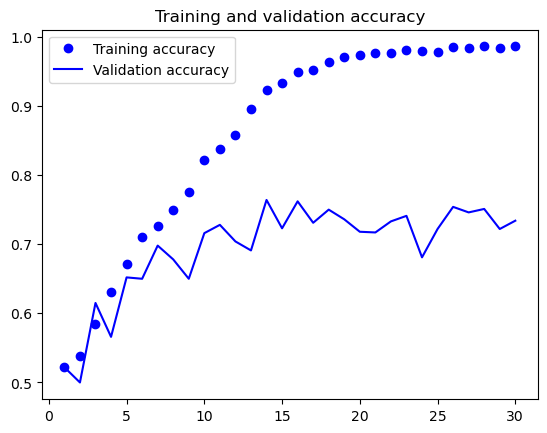

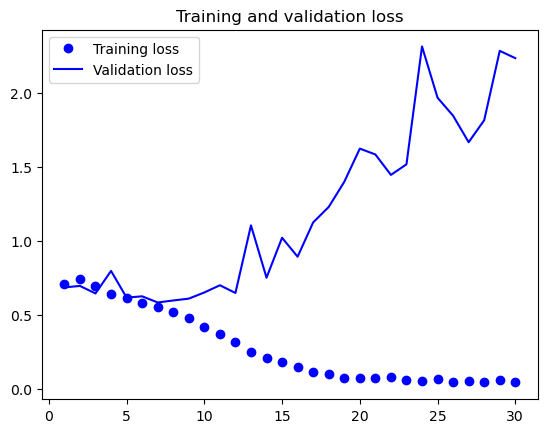

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**테스트 세트에서 모델 평가하기**

In [21]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 31ms/step - loss: 0.5928 - accuracy: 0.6895
테스트 정확도: 0.689


### 데이터 증식 사용하기

**컨브넷에 추가할 데이터 증식 단계 정의하기**

In [22]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    )

**랜덤하게 증식된 훈련 이미지 출력하기**

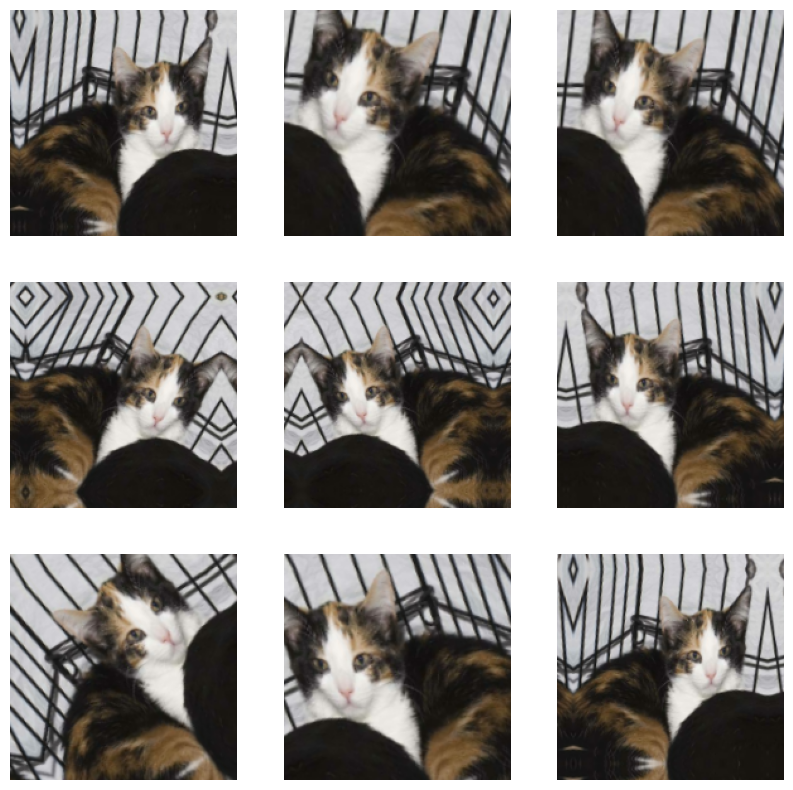

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**이미지 증식과 드롭아웃을 포함한 컨브넷 만들기**

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**규제를 추가한 컨브넷 훈련하기**

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 12s 177ms/step - loss: 0.7172 - accuracy: 0.5050 - val_loss: 0.6911 - val_accuracy: 0.5040
Epoch 2/100
63/63 [==============================] - 11s 171ms/step - loss: 0.6978 - accuracy: 0.5240 - val_loss: 0.6804 - val_accuracy: 0.5850
Epoch 3/100
63/63 [==============================] - 11s 170ms/step - loss: 0.6878 - accuracy: 0.5640 - val_loss: 0.6834 - val_accuracy: 0.5010
Epoch 4/100
63/63 [==============================] - 11s 171ms/step - loss: 0.6587 - accuracy: 0.6105 - val_loss: 0.6158 - val_accuracy: 0.6650
Epoch 5/100
63/63 [==============================] - 11s 170ms/step - loss: 0.6626 - accuracy: 0.6470 - val_loss: 0.6303 - val_accuracy: 0.6420
Epoch 6/100
63/63 [==============================] - 11s 172ms/step - loss: 0.6328 - accuracy: 0.6580 - val_loss: 0.6122 - val_accuracy: 0.6490
Epoch 7/100
63/63 [==============================] - 11s 172ms/step - loss: 0.6314 - accuracy: 0.6555 - val_loss: 0.6206 - val_accuracy:

**테스트 세트에서 모델 훈련하기**

In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 31ms/step - loss: 0.4604 - accuracy: 0.8245
테스트 정확도: 0.825


## 사전 훈련된 모델 활용하기

### 사전 훈련된 모델을 사용한 특성 추출

**VGG16 합성곱 기반 층 만들기**

In [27]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 5s 0us/step


In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### 데이터 증식을 사용하지 않는 빠른 특성 추출

**VGG16 특성과 해당 레이블 추출하기**

In [29]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


In [30]:
train_features.shape

(2000, 5, 5, 512)

**밀집 연결 분류기 정의하고 훈련하기**

In [31]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 17ms/step - loss: 16.5558 - accuracy: 0.9215 - val_loss: 6.7158 - val_accuracy: 0.9540
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 3.7637 - accuracy: 0.9765 - val_loss: 6.0298 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 2.3224 - accuracy: 0.9805 - val_loss: 7.1837 - val_accuracy: 0.9590
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 1.8292 - accuracy: 0.9855 - val_loss: 2.9836 - val_accuracy: 0.9770
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 0.6601 - accuracy: 0.9945 - val_loss: 2.2821 - val_accuracy: 0.9790
Epoch 6/20
63/63 [==============================] - 1s 11ms/step - loss: 0.8661 - accuracy: 0.9945 - val_loss: 3.2160 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 0.4991 - accuracy: 0.9955 - val_loss: 2.8274 - val_accuracy: 0.9830
Epoch 8/20
6

**결과를 그래프로 나타내기**

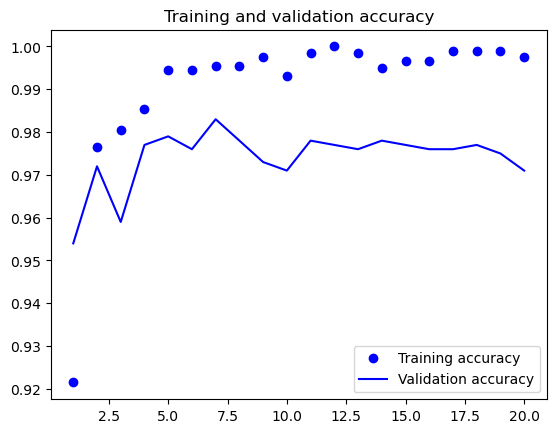

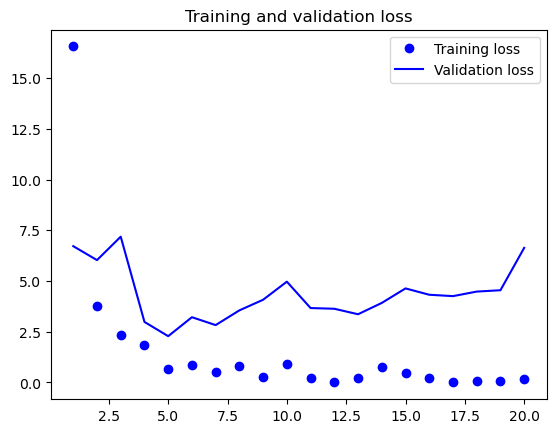

In [32]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [33]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 0s 5ms/step - loss: 3.7362 - accuracy: 0.9760
테스트 정확도: 0.976


#### 데이터 증식을 사용한 특성 추출

**VGG16 합성곱 기반 층을 만들고 동결하기**

In [34]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**동결하기 전과 후에 훈련 가능한 가중치 리스트를 출력하기**

In [35]:
conv_base.trainable = True
print("합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수: 26


In [36]:
conv_base.trainable = False
print("합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수: 0


**데이터 증식 단계와 밀집 분류기를 합성곱 기반 층에 추가하기**

In [39]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    )

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 29s 443ms/step - loss: 19.7426 - accuracy: 0.8905 - val_loss: 4.4574 - val_accuracy: 0.9680
Epoch 2/50
63/63 [==============================] - 27s 437ms/step - loss: 6.7998 - accuracy: 0.9505 - val_loss: 3.8185 - val_accuracy: 0.9680
Epoch 3/50
63/63 [==============================] - 28s 439ms/step - loss: 4.9793 - accuracy: 0.9550 - val_loss: 4.8079 - val_accuracy: 0.9720
Epoch 4/50
63/63 [==============================] - 27s 437ms/step - loss: 4.5821 - accuracy: 0.9585 - val_loss: 2.9788 - val_accuracy: 0.9680
Epoch 5/50
63/63 [==============================] - 27s 437ms/step - loss: 5.7619 - accuracy: 0.9550 - val_loss: 3.4115 - val_accuracy: 0.9740
Epoch 6/50
63/63 [==============================] - 28s 438ms/step - loss: 2.8657 - accuracy: 0.9735 - val_loss: 3.3678 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 28s 437ms/step - loss: 3.1720 - accuracy: 0.9680 - val_loss: 6.3812 - val_accuracy: 0.953

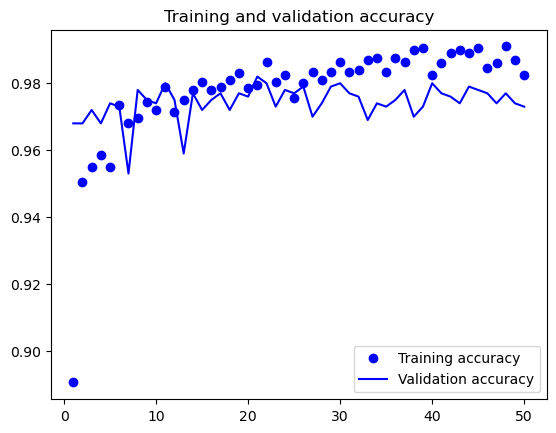

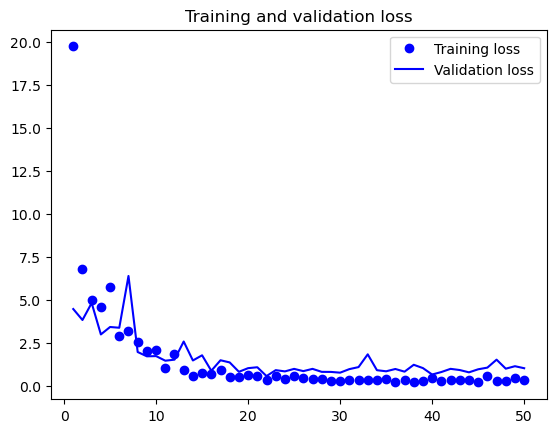

In [41]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**테스트 세트에서 모델 평가하기**

In [42]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 15s 234ms/step - loss: 1.0286 - accuracy: 0.9755
테스트 정확도: 0.975


### 사전 훈련된 모델 미세 조정하기

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**마지막에서 네 번째 층까지 모든 층 동결하기**

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**모델 미세 조정하기**

In [45]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 32s 501ms/step - loss: 0.3103 - accuracy: 0.9875 - val_loss: 0.8590 - val_accuracy: 0.9790
Epoch 2/30
63/63 [==============================] - 31s 486ms/step - loss: 0.1682 - accuracy: 0.9900 - val_loss: 3.4409 - val_accuracy: 0.9560
Epoch 3/30
63/63 [==============================] - 30s 481ms/step - loss: 0.1832 - accuracy: 0.9905 - val_loss: 0.8571 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 30s 481ms/step - loss: 0.2150 - accuracy: 0.9920 - val_loss: 0.6645 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 30s 480ms/step - loss: 0.1264 - accuracy: 0.9940 - val_loss: 0.8009 - val_accuracy: 0.9760
Epoch 6/30
63/63 [==============================] - 31s 488ms/step - loss: 0.0943 - accuracy: 0.9930 - val_loss: 0.9373 - val_accuracy: 0.9740
Epoch 7/30
63/63 [==============================] - 31s 487ms/step - loss: 0.1635 - accuracy: 0.9930 - val_loss: 0.7817 - val_accuracy: 0.9770

In [46]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 15s 234ms/step - loss: 0.9909 - accuracy: 0.9745
테스트 정확도: 0.975
